# Making sure Metropolis-Hastings works

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import tqdm

# Metropolis-Hastings algorithm
- The magnetization needs to be plotted in terms of accepted states

In [189]:
def energy(sequence, J):
    """
    Calculate the Hamiltonian of the sequence.
    Args:
        sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix.
    Returns:
        float: The energy of the current sequence.
    """
    return -np.sum(J * np.outer(sequence, sequence))

def set_interaction_mat(n, prob=[0.7,0.3]):
    # Create an upper triangular matrix with random 0s and 1s
    upper_tri = np.triu(np.random.choice([0, 1], size=(n, n), p=prob), 1)
    # Create the symmetric matrix by adding the upper triangular and its transpose
    symmetric_matrix = upper_tri + upper_tri.T
    # Ensure the diagonal is zero (as commonly expected in adjacency matrices, etc.)
    np.fill_diagonal(symmetric_matrix, 0)
    return symmetric_matrix

# Example usage:
n = 20  # Size of the matrix
matrix = set_interaction_mat(n)
print("Symmetric Random Matrix:\n", matrix)

Symmetric Random Matrix:
 [[0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0]
 [0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0]
 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0]
 [1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0]
 [1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1]
 [0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0]]


## Improvising for real proteins

(108, 108)


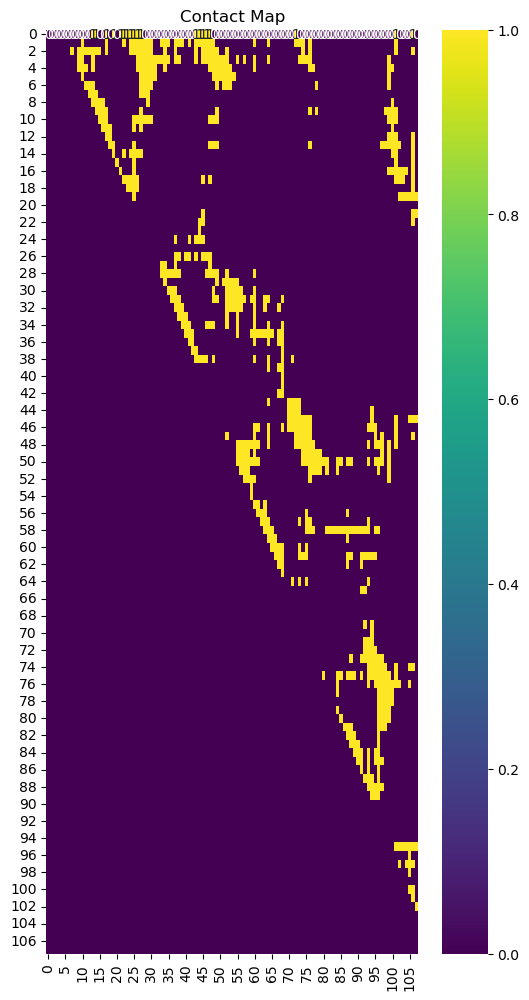

In [203]:
import pickle
# prediction from DCA
file_name = "/Users/mariayuffa/semester-project/bmDCA_contactmaps_npred2L_8A.pkl"
with open(file_name, 'rb') as f:
    matrix = pickle.load(f)
plt.figure(figsize=(6,12))

# actual contact map
mat_contact = np.load("/Users/mariayuffa/semester-project/PF00072_PDB_contact_mask_8A_Allcontacts.npy")
print(mat_contact.shape)

# plotting
#sns.heatmap(np.array(matrix['PF00072']['contact_mask'].astype(int)), cmap='viridis', annot=True)
sns.heatmap(mat_contact, cmap='viridis', annot=True)
plt.title('Contact Map')
# I am not sure if this is interaction matric of a real protein but it will suit as an example of such
#mat = np.array(matrix['PF00072']['contact_mask'].astype(int))
plt.show()

In [201]:
mat_contact = np.load("/Users/mariayuffa/semester-project/PF00072_PDB_contact_mask_8A_Allcontacts.npy")
print(mat_contact.shape)

(108, 108)


In [196]:
def propose_sequence(current_sequence, num_of_flips=1, temp=1.0, with_T_varied=False):
    """
    Propose a new sequence by flipping a set number of spins.
    Args:
        current_sequence (np.array): The current sequence of spins.
        num_of_flips (int): Number of spins to flip.
        temp (int): Temperature
        with_T_varied (bool): adapts the algorithm to the one that is dependent on Temperature rather than number of flips
    Returns:
        np.array: The proposed sequence of spins.
    """
    new_sequence = current_sequence.copy()
    if with_T_varied==False:
        flip_indices = np.random.choice(len(new_sequence), num_of_flips, replace=False)
    else:
        flip_indices = np.random.uniform(0, 1, size=len(new_sequence)) < np.exp(-2/temp)
    #flip_indices = np.random.uniform(0, 1, size=num_of_flips) < prob
    #new_sequence[flip_indices] = -new_sequence[flip_indices]
    new_sequence[flip_indices] *= -1
    return new_sequence

def FindNeighbors(edge_site, J, current_sequence):
    """
    Computes every neighbouring sites of the edge site

    Parameters
    ----------
    edge_site : int
        site number in graph
    tmp_matcontact : 2darray
        adjacency matrix of the graph
    nbrspin : int
        number of sites/nodes in graph

    Returns
    -------
    list_neighbors_site : List
        provides a list of ints corresponding to the neighbouring sites

    """
    list_neighbors_site = {edge_site:[]}
    for l in range(0,edge_site):
        if J[l, edge_site] == 1:
            list_neighbors_site[edge_site].append(l)
            
    for k in range(edge_site+1, len(current_sequence)):
        if J[edge_site,k] == 1:
            list_neighbors_site[edge_site].append(k)
            
    return list_neighbors_site

def ClusterIsing(current_sequence, J, T):
    """
    Algorithm to make one flip in a sequence

    Parameters
    ----------
    nbrspin : int
        number of sites/nodes in graph.
    list_neighbours : List
        List of neighbours, for each key (= one site) it stores a list of neighbours
    tmp_chain : 1d array
        starting sequence .
    p : float
        probability accepting a site in cluster.

    Returns
    -------
    tmp_chain : 1d array
        sequence after cluster flip.

    """
    seq = current_sequence.copy()
    # select randomly the starting site from which the cluster is built
    start_site = np.random.randint(0, len(current_sequence))

    # create the list which contain all sites in the cluster
    cluster = []
    # create the list which contains the sites newly added to explore the 
    # neighbors of them to expand the cluster
    pocket = []
    # contains all the sites forming the cluster
    cluster.append(start_site)
    # contains all the sites which are on the edge of the cluster
    pocket.append(start_site)
    # define a variable containing the spin orientation of the cluster 1 or -1
    spin_orientation = seq[start_site] 

    p = np.exp(-2/T) # 1-np.exp(-2/T) # probability of accepting a site in the cluster
 
    # as long as the cluster is not empty the loop continues
    while pocket:
        # choose one element in the pocket list containing edge sites
        pocket_site = np.random.choice(np.array(pocket))
        list_neighbours = FindNeighbors(pocket_site, J, seq)
        for site in list_neighbours[pocket_site]:
            # if the site is not in the cluster and the spin orientation is the same
            if (site not in cluster) and (seq[site] == spin_orientation) and (np.random.uniform(0.0,1.0)>p):
                pocket.append(site)
                cluster.append(site)

        pocket.remove(pocket_site)

    for elem in cluster:
            seq[elem] = -seq[elem]
    return seq


def metropolis_hastings(J, initial_sequences, num_iters, T=1.0, num_of_flips=1, with_T_varied=False):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
        with_T_varied (bool): adapts the algorithm to the one that is dependent on Temperature rather than number of flips
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    log_sequences = np.zeros((len(current_sequences), num_iters))
    updated_log_sequences = []
    accepted_states = np.zeros(len(current_sequences))
    for n in tqdm.tqdm((range(num_iters))):
        for i in range(len(current_sequences)):
            if with_T_varied==False:
                num_of_flips = np.random.randint(1,20)
            #proposed_sequence = propose_sequence(current_sequences[i], num_of_flips)
            print("Before flipping:",np.sum(current_sequences[i]))
            #proposed_sequence = identify_and_flip_clusters(current_sequences[i], J, T)
            proposed_sequence = ClusterIsing(current_sequences[i], J, T)
            print("After flipping:",np.sum(proposed_sequence))
            current_energy = energy(current_sequences[i], J)
            proposed_energy = energy(proposed_sequence, J)
            energy_difference = proposed_energy - current_energy
            if (energy_difference < 0):
                print("accepting the proposed sequence")
                current_sequences[i] = proposed_sequence
                accepted_states[i]+=1
            # if in the cluster Isign we already consider the temperature (higher temperature more flips)
            # there is no utility in considering the else clause
            
            #else:
            #    if np.random.uniform(0,1)<np.exp(-energy_difference/T):
            #        print("accepting the proposed sequence")
            #        current_sequences[i] = proposed_sequence
            #        #log_sequences[:,accepted_states[i]] = np.absolute(np.sum(np.array(current_sequences), axis=1))
            #        accepted_states[i]+=1
            #    else:
            #        print("rejecting the proposed sequence")
        log_sequences[:,n] = np.absolute(np.sum(np.stack(current_sequences), axis=1)/len(current_sequences[0]))

    #for i in range(len(current_sequences)):
    #    updated_log_sequences.append(np.unique(log_sequences[i,:]))
    return current_sequences, log_sequences, accepted_states

# Example usage:
np.random.seed(42)  # For reproducibility

size = 108  # Size of each sequence
num_sequences = 100  # Number of sequences
#J = set_interaction_mat(size, prob=[0.7,0.3]) # Example interaction matrix, should be symmetric
J = np.array(matrix['PF00072']['contact_mask'].astype(int))
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences_train, log_sequences, accepted_states = metropolis_hastings(J, initial_sequences, num_iters=100, T=3, num_of_flips=10, with_T_varied=False)
# Final_sequences contains the sequences after they have potentially reached their stable states


  4%|▍         | 4/100 [00:00<00:02, 37.71it/s]

Before flipping: 18
After flipping: 6
accepting the proposed sequence
Before flipping: -24
After flipping: -22
accepting the proposed sequence
Before flipping: 6
After flipping: 4
accepting the proposed sequence
Before flipping: 10
After flipping: -4
accepting the proposed sequence
Before flipping: 4
After flipping: -2
accepting the proposed sequence
Before flipping: 12
After flipping: 10
accepting the proposed sequence
Before flipping: 10
After flipping: 6
accepting the proposed sequence
Before flipping: -20
After flipping: -18
accepting the proposed sequence
Before flipping: -12
After flipping: 2
accepting the proposed sequence
Before flipping: -8
After flipping: 2
accepting the proposed sequence
Before flipping: 6
After flipping: -16
accepting the proposed sequence
Before flipping: -8
After flipping: -6
accepting the proposed sequence
Before flipping: 6
After flipping: 4
Before flipping: -6
After flipping: 14
accepting the proposed sequence
Before flipping: 0
After flipping: -20
acc

  8%|▊         | 8/100 [00:00<00:04, 21.96it/s]

accepting the proposed sequence
Before flipping: 14
After flipping: 18
accepting the proposed sequence
Before flipping: -66
After flipping: 82
accepting the proposed sequence
Before flipping: -34
After flipping: -24
Before flipping: -8
After flipping: 56
accepting the proposed sequence
Before flipping: 14
After flipping: 26
accepting the proposed sequence
Before flipping: 74
After flipping: -64
accepting the proposed sequence
Before flipping: 24
After flipping: -22
accepting the proposed sequence
Before flipping: 74
After flipping: -74
accepting the proposed sequence
Before flipping: -60
After flipping: 58
Before flipping: -46
After flipping: 78
accepting the proposed sequence
Before flipping: -42
After flipping: 70
accepting the proposed sequence
Before flipping: -74
After flipping: -76
accepting the proposed sequence
Before flipping: -58
After flipping: 82
accepting the proposed sequence
Before flipping: 74
After flipping: 72
Before flipping: -46
After flipping: -74
accepting the pro

 11%|█         | 11/100 [00:00<00:05, 17.12it/s]

Before flipping: -54
After flipping: -68
accepting the proposed sequence
Before flipping: -54
After flipping: -50
Before flipping: 70
After flipping: -86
accepting the proposed sequence
Before flipping: -4
After flipping: 12
accepting the proposed sequence
Before flipping: 74
After flipping: -68
Before flipping: -78
After flipping: 38
Before flipping: 40
After flipping: -54
accepting the proposed sequence
Before flipping: -64
After flipping: 62
accepting the proposed sequence
Before flipping: -16
After flipping: -4
accepting the proposed sequence
Before flipping: 32
After flipping: -78
accepting the proposed sequence
Before flipping: -56
After flipping: -54
Before flipping: 16
After flipping: 14
Before flipping: 42
After flipping: 32
Before flipping: 24
After flipping: 26
accepting the proposed sequence
Before flipping: -48
After flipping: 88
accepting the proposed sequence
Before flipping: -18
After flipping: 50
accepting the proposed sequence
Before flipping: 58
After flipping: 60
ac

 13%|█▎        | 13/100 [00:00<00:05, 14.79it/s]

Before flipping: -80
After flipping: 60
Before flipping: -16
After flipping: -14
accepting the proposed sequence
Before flipping: -32
After flipping: -38
accepting the proposed sequence
Before flipping: -82
After flipping: 2
Before flipping: -68
After flipping: 66
Before flipping: -46
After flipping: -48
accepting the proposed sequence
Before flipping: 78
After flipping: -76
Before flipping: -68
After flipping: -4
Before flipping: 10
After flipping: 44
accepting the proposed sequence
Before flipping: 70
After flipping: 68
Before flipping: -62
After flipping: 68
accepting the proposed sequence
Before flipping: 80
After flipping: -70
Before flipping: -58
After flipping: 76
accepting the proposed sequence
Before flipping: 42
After flipping: 46
accepting the proposed sequence
Before flipping: 68
After flipping: -66
Before flipping: -62
After flipping: -22
Before flipping: -38
After flipping: -36
Before flipping: 76
After flipping: -70
Before flipping: -68
After flipping: 34
Before flipping

 15%|█▌        | 15/100 [00:01<00:07, 11.23it/s]

Before flipping: -68
After flipping: 70
Before flipping: -68
After flipping: 66
Before flipping: -70
After flipping: -72
accepting the proposed sequence
Before flipping: 82
After flipping: 78
Before flipping: -84
After flipping: 72
Before flipping: -68
After flipping: -66
Before flipping: -84
After flipping: 78
Before flipping: 80
After flipping: 78
Before flipping: 90
After flipping: -66
Before flipping: 76
After flipping: -72
Before flipping: 88
After flipping: -36
Before flipping: 78
After flipping: -84
Before flipping: 88
After flipping: -72
Before flipping: 82
After flipping: 84
Before flipping: 82
After flipping: -60
Before flipping: 82
After flipping: -66
Before flipping: -82
After flipping: -80
Before flipping: 92
After flipping: 90
Before flipping: 66
After flipping: -58
Before flipping: -70
After flipping: -68
Before flipping: -68
After flipping: 68
accepting the proposed sequence
Before flipping: 82
After flipping: 78
accepting the proposed sequence
Before flipping: -76
Afte

 17%|█▋        | 17/100 [00:01<00:07, 11.02it/s]

Before flipping: 66
After flipping: 64
Before flipping: -72
After flipping: -76
accepting the proposed sequence
Before flipping: 70
After flipping: -64
Before flipping: 78
After flipping: -48
Before flipping: 76
After flipping: -86
accepting the proposed sequence
Before flipping: -86
After flipping: -64
Before flipping: -52
After flipping: 62
accepting the proposed sequence
Before flipping: -84
After flipping: 54
Before flipping: -82
After flipping: -80
Before flipping: -74
After flipping: 68
Before flipping: -82
After flipping: 62
Before flipping: -80
After flipping: 68
Before flipping: -80
After flipping: -78
Before flipping: 78
After flipping: 76
Before flipping: 24
After flipping: 0
Before flipping: 40
After flipping: -30
Before flipping: -36
After flipping: -60
accepting the proposed sequence
Before flipping: 88
After flipping: -70
Before flipping: -66
After flipping: 66
Before flipping: -68
After flipping: 72
Before flipping: 84
After flipping: -54
Before flipping: 80
After flipp

 19%|█▉        | 19/100 [00:01<00:07, 10.34it/s]

Before flipping: -76
After flipping: -74
Before flipping: 80
After flipping: -72
Before flipping: -68
After flipping: 82
accepting the proposed sequence
Before flipping: 72
After flipping: -78
accepting the proposed sequence
Before flipping: -74
After flipping: 86
accepting the proposed sequence
Before flipping: 82
After flipping: -72
Before flipping: -82
After flipping: -84
accepting the proposed sequence
Before flipping: -68
After flipping: 78
Before flipping: -84
After flipping: 56
Before flipping: 82
After flipping: -70
Before flipping: 90
After flipping: -50
Before flipping: 76
After flipping: 78
accepting the proposed sequence
Before flipping: 90
After flipping: -68
Before flipping: 78
After flipping: -78
Before flipping: 88
After flipping: -56
Before flipping: 82
After flipping: -30
Before flipping: 82
After flipping: -70
Before flipping: 84
After flipping: -80
Before flipping: -82
After flipping: 74
accepting the proposed sequence
Before flipping: 92
After flipping: -76
Before 

 21%|██        | 21/100 [00:01<00:07, 10.23it/s]

Before flipping: -78
After flipping: 76
accepting the proposed sequence
Before flipping: 86
After flipping: 88
Before flipping: 82
After flipping: 84
Before flipping: -84
After flipping: 78
Before flipping: -68
After flipping: 76
accepting the proposed sequence
Before flipping: -84
After flipping: 82
accepting the proposed sequence
Before flipping: 82
After flipping: -58
Before flipping: 90
After flipping: 86
Before flipping: 78
After flipping: -66
Before flipping: 90
After flipping: -34
Before flipping: 78
After flipping: 76
Before flipping: 88
After flipping: -68
Before flipping: 82
After flipping: 80
Before flipping: 82
After flipping: 84
accepting the proposed sequence
Before flipping: 84
After flipping: 82
Before flipping: 74
After flipping: -72
Before flipping: 92
After flipping: 94
Before flipping: -86
After flipping: -88
accepting the proposed sequence
Before flipping: -76
After flipping: 78
accepting the proposed sequence
Before flipping: 70
After flipping: -70
Before flipping

 23%|██▎       | 23/100 [00:01<00:07,  9.92it/s]

Before flipping: -82
After flipping: 58
Before flipping: 70
After flipping: 72
accepting the proposed sequence
Before flipping: 82
After flipping: 80
Before flipping: -76
After flipping: -78
accepting the proposed sequence
Before flipping: 80
After flipping: -78
Before flipping: 82
After flipping: -68
Before flipping: 76
After flipping: -46
Before flipping: 86
After flipping: -62
Before flipping: 82
After flipping: -76
Before flipping: -84
After flipping: -80
Before flipping: 76
After flipping: -70
accepting the proposed sequence
Before flipping: 82
After flipping: -80
Before flipping: 82
After flipping: 80
Before flipping: 90
After flipping: -62
Before flipping: 78
After flipping: -74
Before flipping: 90
After flipping: -38
Before flipping: 78
After flipping: -80
Before flipping: 88
After flipping: -64
Before flipping: 82
After flipping: -50
Before flipping: 84
After flipping: 86
accepting the proposed sequence
Before flipping: 84
After flipping: -54
Before flipping: -82
After flippin

 25%|██▌       | 25/100 [00:02<00:07,  9.84it/s]

accepting the proposed sequence
Before flipping: 80
After flipping: 84
accepting the proposed sequence
Before flipping: -88
After flipping: 60
Before flipping: -76
After flipping: -80
accepting the proposed sequence
Before flipping: -86
After flipping: 68
Before flipping: 86
After flipping: 84
Before flipping: -92
After flipping: 60
Before flipping: 88
After flipping: 86
Before flipping: -82
After flipping: -80
Before flipping: -80
After flipping: 40
Before flipping: 82
After flipping: -64
Before flipping: -78
After flipping: 78
accepting the proposed sequence
Before flipping: 80
After flipping: -66
Before flipping: 82
After flipping: -70
Before flipping: 76
After flipping: -50
Before flipping: 86
After flipping: -48
Before flipping: 82
After flipping: -72
Before flipping: -84
After flipping: 68
Before flipping: -70
After flipping: 88
accepting the proposed sequence
Before flipping: 82
After flipping: 80
Before flipping: 82
After flipping: 80
Before flipping: 90
After flipping: 92
Befo

 28%|██▊       | 28/100 [00:02<00:07,  9.53it/s]

Before flipping: 94
After flipping: -64
Before flipping: -74
After flipping: -66
Before flipping: -84
After flipping: 54
Before flipping: 80
After flipping: -70
Before flipping: -76
After flipping: 44
Before flipping: -78
After flipping: 72
Before flipping: -84
After flipping: 72
Before flipping: 84
After flipping: -40
Before flipping: 84
After flipping: -82
Before flipping: -88
After flipping: -90
accepting the proposed sequence
Before flipping: -80
After flipping: -84
accepting the proposed sequence
Before flipping: -86
After flipping: 88
Before flipping: 86
After flipping: 88
Before flipping: -92
After flipping: 42
Before flipping: 88
After flipping: -70
Before flipping: -82
After flipping: 50
Before flipping: -80
After flipping: 80
Before flipping: 82
After flipping: -70
Before flipping: 78
After flipping: 68
Before flipping: 80
After flipping: -66
Before flipping: 82
After flipping: -72
Before flipping: 76
After flipping: -72
Before flipping: 86
After flipping: -66
Before flipping

 29%|██▉       | 29/100 [00:02<00:07,  9.45it/s]

Before flipping: -80
After flipping: 52
Before flipping: 76
After flipping: -70
Before flipping: 84
After flipping: -68
Before flipping: 84
After flipping: 86
Before flipping: 82
After flipping: -42
Before flipping: -90
After flipping: 56
Before flipping: -88
After flipping: 72
Before flipping: -80
After flipping: -76
Before flipping: 90
After flipping: -50
Before flipping: 98
After flipping: 96
Before flipping: 86
After flipping: 84
Before flipping: -90
After flipping: -74
Before flipping: -94
After flipping: 70
Before flipping: -76
After flipping: 78
Before flipping: -82
After flipping: -84
accepting the proposed sequence
Before flipping: -76
After flipping: -78
accepting the proposed sequence
Before flipping: -76
After flipping: 46
Before flipping: -86
After flipping: -84
Before flipping: 74
After flipping: 72
Before flipping: -80
After flipping: -84
accepting the proposed sequence
Before flipping: 90
After flipping: 74
Before flipping: 80
After flipping: -74
Before flipping: 94
Aft

 32%|███▏      | 32/100 [00:02<00:07,  9.46it/s]

Before flipping: -90
After flipping: 68
Before flipping: -88
After flipping: 72
Before flipping: -80
After flipping: 34
Before flipping: 90
After flipping: -70
Before flipping: 98
After flipping: -48
Before flipping: 86
After flipping: 88
Before flipping: -90
After flipping: 74
Before flipping: -98
After flipping: 60
Before flipping: -76
After flipping: 66
Before flipping: -84
After flipping: -82
Before flipping: -78
After flipping: -74
Before flipping: -76
After flipping: 56
Before flipping: -86
After flipping: 54
Before flipping: 74
After flipping: -80
accepting the proposed sequence
Before flipping: -84
After flipping: 82
Before flipping: 90
After flipping: -56
Before flipping: 80
After flipping: -80
Before flipping: 96
After flipping: -60
Before flipping: -74
After flipping: 72
Before flipping: -84
After flipping: 50
Before flipping: 82
After flipping: -34
Before flipping: 74
After flipping: 76
Before flipping: -80
After flipping: 62
Before flipping: -84
After flipping: 72
Before f

 33%|███▎      | 33/100 [00:02<00:07,  9.51it/s]

Before flipping: -78
After flipping: -76
Before flipping: 86
After flipping: 84
Before flipping: 86
After flipping: -60
Before flipping: 86
After flipping: 84
Before flipping: -86
After flipping: -82
Before flipping: -88
After flipping: 60
Before flipping: 90
After flipping: -56
Before flipping: -82
After flipping: 74
Before flipping: 72
After flipping: -74
Before flipping: -74
After flipping: -72
Before flipping: -86
After flipping: 60
Before flipping: -86
After flipping: 76
Before flipping: -78
After flipping: -80
accepting the proposed sequence
Before flipping: 76
After flipping: -70
Before flipping: 84
After flipping: 80
accepting the proposed sequence
Before flipping: 84
After flipping: -54
Before flipping: 84
After flipping: -72
Before flipping: -92
After flipping: -94
Before flipping: -88
After flipping: 66
Before flipping: -80
After flipping: 76
Before flipping: 90
After flipping: 76
Before flipping: 98
After flipping: 96
Before flipping: 86
After flipping: -70
Before flipping:

 35%|███▌      | 35/100 [00:03<00:07,  9.08it/s]

Before flipping: -84
After flipping: 60
Before flipping: 84
After flipping: -62
Before flipping: 82
After flipping: -64
Before flipping: -58
After flipping: -56
accepting the proposed sequence
Before flipping: 84
After flipping: 64
Before flipping: -78
After flipping: 62
Before flipping: -72
After flipping: 74
Before flipping: -86
After flipping: 70
Before flipping: -94
After flipping: -92
Before flipping: 90
After flipping: -46
Before flipping: -84
After flipping: -82
Before flipping: -88
After flipping: 70
Before flipping: -86
After flipping: 82
Before flipping: -82
After flipping: 52
Before flipping: 76
After flipping: -80
Before flipping: 80
After flipping: -76
Before flipping: 86
After flipping: -62
Before flipping: -78
After flipping: 70
Before flipping: 86
After flipping: -60
Before flipping: -74
After flipping: 86
Before flipping: 86
After flipping: -74
Before flipping: -86
After flipping: 36
Before flipping: -88
After flipping: 68
Before flipping: 90
After flipping: -48
Before

 37%|███▋      | 37/100 [00:03<00:06,  9.15it/s]

Before flipping: 80
After flipping: -46
Before flipping: 88
After flipping: -68
Before flipping: 84
After flipping: -74
Before flipping: 90
After flipping: -74
Before flipping: 84
After flipping: 82
Before flipping: -86
After flipping: 66
Before flipping: 94
After flipping: -76
Before flipping: -88
After flipping: 82
Before flipping: -86
After flipping: 72
Before flipping: -86
After flipping: 76
Before flipping: -88
After flipping: -92
accepting the proposed sequence
Before flipping: -86
After flipping: 62
Before flipping: 84
After flipping: 86
accepting the proposed sequence
Before flipping: 74
After flipping: 70
Before flipping: -86
After flipping: 76
Before flipping: -88
After flipping: -78
Before flipping: -74
After flipping: 54
Before flipping: -82
After flipping: 68
Before flipping: -84
After flipping: -82
Before flipping: 84
After flipping: 86
accepting the proposed sequence
Before flipping: 82
After flipping: -56
Before flipping: -56
After flipping: 88
accepting the proposed se

 39%|███▉      | 39/100 [00:03<00:06,  8.85it/s]

Before flipping: -80
After flipping: 62
Before flipping: 84
After flipping: 70
Before flipping: 80
After flipping: 78
Before flipping: 84
After flipping: -44
Before flipping: -82
After flipping: 56
Before flipping: 82
After flipping: 0
Before flipping: 88
After flipping: -60
Before flipping: -84
After flipping: 54
Before flipping: -86
After flipping: -84
Before flipping: 94
After flipping: -76
Before flipping: -88
After flipping: -90
Before flipping: -70
After flipping: 82
Before flipping: 92
After flipping: -54
Before flipping: 80
After flipping: -78
Before flipping: 90
After flipping: -54
Before flipping: 80
After flipping: -78
Before flipping: 88
After flipping: -68
Before flipping: 84
After flipping: 86
Before flipping: 90
After flipping: 88
Before flipping: 84
After flipping: -54
Before flipping: -86
After flipping: -88
accepting the proposed sequence
Before flipping: 94
After flipping: 90
Before flipping: -88
After flipping: 44
Before flipping: -86
After flipping: 66
Before flipp

 40%|████      | 40/100 [00:03<00:06,  8.98it/s]

Before flipping: -76
After flipping: 84
Before flipping: -84
After flipping: 48
Before flipping: 78
After flipping: -70
Before flipping: -76
After flipping: 62
Before flipping: -88
After flipping: 30
Before flipping: 78
After flipping: -80
Before flipping: -86
After flipping: -82
Before flipping: 94
After flipping: 96
Before flipping: 80
After flipping: -78
Before flipping: 96
After flipping: -54
Before flipping: 84
After flipping: 82
Before flipping: 82
After flipping: 80
Before flipping: 84
After flipping: -58
Before flipping: -80
After flipping: 64
Before flipping: -80
After flipping: 64
Before flipping: 82
After flipping: -80
Before flipping: 82
After flipping: -46
Before flipping: 84
After flipping: 82
Before flipping: -90
After flipping: 72
Before flipping: -86
After flipping: -88
Before flipping: 88
After flipping: -82
Before flipping: -84
After flipping: 60
Before flipping: -94
After flipping: 34
Before flipping: 88
After flipping: 84
Before flipping: -82
After flipping: 68
Bef

 43%|████▎     | 43/100 [00:04<00:06,  9.30it/s]

Before flipping: 80
After flipping: -78
accepting the proposed sequence
Before flipping: -80
After flipping: 58
Before flipping: -88
After flipping: 76
Before flipping: 78
After flipping: 80
accepting the proposed sequence
Before flipping: -86
After flipping: 68
Before flipping: 94
After flipping: 92
Before flipping: 80
After flipping: 82
accepting the proposed sequence
Before flipping: 96
After flipping: -76
Before flipping: 86
After flipping: -72
Before flipping: 84
After flipping: 86
accepting the proposed sequence
Before flipping: 84
After flipping: -76
Before flipping: -80
After flipping: 64
Before flipping: -80
After flipping: -78
Before flipping: 82
After flipping: -68
Before flipping: 82
After flipping: -58
Before flipping: 84
After flipping: -60
Before flipping: -90
After flipping: -88
Before flipping: -86
After flipping: 68
Before flipping: 88
After flipping: -80
Before flipping: -84
After flipping: 62
Before flipping: 78
After flipping: -86
Before flipping: 88
After flipping

 45%|████▌     | 45/100 [00:04<00:05,  9.35it/s]

Before flipping: 80
After flipping: 78
Before flipping: -82
After flipping: 56
Before flipping: 86
After flipping: 82
Before flipping: 88
After flipping: 86
Before flipping: -92
After flipping: -90
Before flipping: -94
After flipping: -92
Before flipping: 84
After flipping: -66
Before flipping: 90
After flipping: -62
Before flipping: 98
After flipping: 96
Before flipping: 88
After flipping: 86
Before flipping: -90
After flipping: 52
Before flipping: -98
After flipping: -92
Before flipping: -76
After flipping: 78
Before flipping: -84
After flipping: 72
Before flipping: -78
After flipping: -76
Before flipping: -80
After flipping: -74
Before flipping: -88
After flipping: 70
Before flipping: 80
After flipping: 82
accepting the proposed sequence
Before flipping: -86
After flipping: 66
Before flipping: 94
After flipping: 92
Before flipping: 82
After flipping: -66
Before flipping: 96
After flipping: -66
Before flipping: 86
After flipping: -62
Before flipping: 86
After flipping: 84
Before flip

 46%|████▌     | 46/100 [00:04<00:05,  9.22it/s]

Before flipping: 86
After flipping: -74
Before flipping: 74
After flipping: 76
accepting the proposed sequence
Before flipping: -88
After flipping: -84
Before flipping: -72
After flipping: 64
Before flipping: -82
After flipping: 74
Before flipping: -98
After flipping: 62
Before flipping: -74
After flipping: 78
Before flipping: -86
After flipping: 76
Before flipping: -86
After flipping: 80
accepting the proposed sequence
Before flipping: -82
After flipping: -88
accepting the proposed sequence
Before flipping: 80
After flipping: -80
Before flipping: -84
After flipping: 64
Before flipping: 86
After flipping: -54
Before flipping: 88
After flipping: -78
Before flipping: -92
After flipping: -90
Before flipping: -94
After flipping: -96
Before flipping: 84
After flipping: 82
Before flipping: 90
After flipping: -70
Before flipping: 98
After flipping: 96
Before flipping: 88
After flipping: 90
accepting the proposed sequence
Before flipping: -90
After flipping: 62
Before flipping: -98
After flipp

 48%|████▊     | 48/100 [00:04<00:05,  8.91it/s]

Before flipping: -76
After flipping: 82
Before flipping: 74
After flipping: -70
Before flipping: -84
After flipping: 68
Before flipping: 90
After flipping: -56
Before flipping: 90
After flipping: 82
Before flipping: 90
After flipping: -52
Before flipping: 86
After flipping: -74
Before flipping: -78
After flipping: 74
Before flipping: -78
After flipping: -72
Before flipping: -90
After flipping: 68
Before flipping: -94
After flipping: 42
Before flipping: 94
After flipping: 92
Before flipping: -88
After flipping: 54
Before flipping: -88
After flipping: 76
Before flipping: -90
After flipping: -88
Before flipping: -84
After flipping: -86
Before flipping: 86
After flipping: -70
Before flipping: 86
After flipping: -70
Before flipping: 88
After flipping: -48
Before flipping: -84
After flipping: 56
Before flipping: 90
After flipping: -72
Before flipping: -76
After flipping: -72
Before flipping: 86
After flipping: -52
Before flipping: 76
After flipping: 74
Before flipping: -88
After flipping: 62

 49%|████▉     | 49/100 [00:04<00:05,  9.00it/s]

Before flipping: 94
After flipping: -44
Before flipping: -88
After flipping: 70
Before flipping: 92
After flipping: -52
Before flipping: 94
After flipping: -34
Before flipping: 80
After flipping: -78
Before flipping: 90
After flipping: 84
Before flipping: 82
After flipping: 84
accepting the proposed sequence
Before flipping: 94
After flipping: 92
Before flipping: 84
After flipping: 78
Before flipping: 90
After flipping: -56
Before flipping: 84
After flipping: -70
Before flipping: -90
After flipping: 48
Before flipping: 94
After flipping: 92
Before flipping: -92
After flipping: -90
Before flipping: -88
After flipping: 64
Before flipping: 78
After flipping: -70
Before flipping: -92
After flipping: 68
Before flipping: -94
After flipping: 66
Before flipping: 90
After flipping: -62
Before flipping: -90
After flipping: -88
Before flipping: -86
After flipping: 54
Before flipping: -88
After flipping: 58
Before flipping: -76
After flipping: -74
Before flipping: -82
After flipping: 58
Before fli

 52%|█████▏    | 52/100 [00:05<00:05,  9.02it/s]

Before flipping: 88
After flipping: -58
Before flipping: -88
After flipping: -86
Before flipping: -86
After flipping: 74
Before flipping: 94
After flipping: -48
Before flipping: -88
After flipping: -84
Before flipping: 92
After flipping: -58
Before flipping: 94
After flipping: -60
Before flipping: 80
After flipping: -64
Before flipping: 90
After flipping: -38
Before flipping: 84
After flipping: 82
Before flipping: 94
After flipping: -54
Before flipping: 84
After flipping: -72
Before flipping: 90
After flipping: -56
Before flipping: 84
After flipping: 82
accepting the proposed sequence
Before flipping: -90
After flipping: 70
Before flipping: 94
After flipping: -72
Before flipping: -92
After flipping: -90
Before flipping: -88
After flipping: 56
Before flipping: 80
After flipping: -74
Before flipping: -92
After flipping: 58
Before flipping: -94
After flipping: -88
Before flipping: 90
After flipping: 88
Before flipping: -90
After flipping: 58
Before flipping: -86
After flipping: 44
Before 

 54%|█████▍    | 54/100 [00:05<00:05,  9.11it/s]

Before flipping: 88
After flipping: -62
Before flipping: 86
After flipping: -72
Before flipping: -92
After flipping: 50
Before flipping: -80
After flipping: 66
Before flipping: -84
After flipping: -82
Before flipping: 86
After flipping: -54
Before flipping: 82
After flipping: -66
Before flipping: 86
After flipping: -54
Before flipping: -90
After flipping: 38
Before flipping: -88
After flipping: 72
Before flipping: -92
After flipping: 58
Before flipping: -84
After flipping: 62
Before flipping: 84
After flipping: -66
Before flipping: 88
After flipping: -56
Before flipping: -90
After flipping: 62
Before flipping: -80
After flipping: -76
Before flipping: 88
After flipping: 90
accepting the proposed sequence
Before flipping: 80
After flipping: -70
Before flipping: -84
After flipping: -82
Before flipping: -88
After flipping: 50
Before flipping: 84
After flipping: -64
Before flipping: 88
After flipping: 90
Before flipping: -88
After flipping: 56
Before flipping: -86
After flipping: 72
Before 

 56%|█████▌    | 56/100 [00:05<00:04,  9.07it/s]

Before flipping: 88
After flipping: 86
Before flipping: 92
After flipping: -42
Before flipping: 98
After flipping: -58
Before flipping: 92
After flipping: 80
Before flipping: -92
After flipping: 62
Before flipping: -100
After flipping: 40
Before flipping: 92
After flipping: -70
Before flipping: -86
After flipping: 72
Before flipping: -78
After flipping: 74
Before flipping: -80
After flipping: 74
Before flipping: -88
After flipping: 52
Before flipping: 82
After flipping: -58
Before flipping: -88
After flipping: -78
Before flipping: 94
After flipping: -42
Before flipping: 86
After flipping: 82
Before flipping: 96
After flipping: -52
Before flipping: 88
After flipping: -68
Before flipping: 86
After flipping: -74
Before flipping: -92
After flipping: 76
Before flipping: -80
After flipping: 58
Before flipping: -84
After flipping: 30
Before flipping: 86
After flipping: -60
Before flipping: 82
After flipping: -72
Before flipping: 86
After flipping: 88
accepting the proposed sequence
Before fli

 57%|█████▋    | 57/100 [00:05<00:04,  9.20it/s]

Before flipping: -84
After flipping: -86
Before flipping: 90
After flipping: -44
Before flipping: 80
After flipping: 82
Before flipping: 88
After flipping: -68
Before flipping: 76
After flipping: -78
Before flipping: -88
After flipping: -90
Before flipping: 90
After flipping: -78
Before flipping: -82
After flipping: -80
Before flipping: -98
After flipping: -100
accepting the proposed sequence
Before flipping: -74
After flipping: 78
Before flipping: -86
After flipping: 70
Before flipping: 80
After flipping: -88
Before flipping: 86
After flipping: -84
Before flipping: 80
After flipping: 82
accepting the proposed sequence
Before flipping: -84
After flipping: 64
Before flipping: 86
After flipping: -30
Before flipping: 92
After flipping: 90
Before flipping: -98
After flipping: 68
Before flipping: -94
After flipping: 80
Before flipping: 88
After flipping: -78
Before flipping: 92
After flipping: -66
Before flipping: 98
After flipping: 88
Before flipping: 92
After flipping: 90
Before flipping:

 59%|█████▉    | 59/100 [00:05<00:04,  9.18it/s]

Before flipping: -78
After flipping: 72
Before flipping: -80
After flipping: 60
Before flipping: -92
After flipping: 70
Before flipping: -94
After flipping: 50
Before flipping: 96
After flipping: 94
Before flipping: -90
After flipping: 68
Before flipping: -88
After flipping: -86
Before flipping: -90
After flipping: 60
Before flipping: -86
After flipping: 34
Before flipping: 92
After flipping: 86
Before flipping: 86
After flipping: -68
Before flipping: 88
After flipping: -52
Before flipping: -84
After flipping: 58
Before flipping: 90
After flipping: 88
Before flipping: 80
After flipping: -82
Before flipping: 88
After flipping: -66
Before flipping: 82
After flipping: -74
Before flipping: -90
After flipping: 76
Before flipping: 90
After flipping: -70
Before flipping: -82
After flipping: 76
Before flipping: -100
After flipping: -98
Before flipping: -74
After flipping: 82
accepting the proposed sequence
Before flipping: -90
After flipping: 58
Before flipping: 80
After flipping: -74
Before f

 61%|██████    | 61/100 [00:06<00:04,  9.04it/s]

Before flipping: -88
After flipping: 58
Before flipping: 80
After flipping: -52
Before flipping: -94
After flipping: -92
Before flipping: -94
After flipping: -90
Before flipping: 90
After flipping: -80
Before flipping: -92
After flipping: 70
Before flipping: 78
After flipping: -80
Before flipping: -88
After flipping: 62
Before flipping: -78
After flipping: -76
Before flipping: 82
After flipping: -68
Before flipping: -84
After flipping: -82
Before flipping: 96
After flipping: -42
Before flipping: 92
After flipping: -56
Before flipping: 90
After flipping: 92
accepting the proposed sequence
Before flipping: -84
After flipping: 78
Before flipping: -78
After flipping: -80
accepting the proposed sequence
Before flipping: -80
After flipping: 78
Before flipping: -92
After flipping: -90
Before flipping: -94
After flipping: 40
Before flipping: 96
After flipping: -56
Before flipping: -90
After flipping: 72
Before flipping: -88
After flipping: 62
Before flipping: -90
After flipping: -88
Before fli

 63%|██████▎   | 63/100 [00:06<00:04,  8.85it/s]

Before flipping: -84
After flipping: 54
Before flipping: -90
After flipping: 80
Before flipping: 84
After flipping: 86
accepting the proposed sequence
Before flipping: 92
After flipping: -78
Before flipping: -92
After flipping: 54
Before flipping: -88
After flipping: 70
Before flipping: 94
After flipping: 96
Before flipping: -88
After flipping: -92
accepting the proposed sequence
Before flipping: 92
After flipping: -48
Before flipping: 96
After flipping: -28
Before flipping: -86
After flipping: 82
Before flipping: 98
After flipping: -62
Before flipping: 86
After flipping: -78
Before flipping: 94
After flipping: 92
Before flipping: 86
After flipping: -52
Before flipping: 90
After flipping: -54
Before flipping: 94
After flipping: -66
Before flipping: -90
After flipping: -92
accepting the proposed sequence
Before flipping: 96
After flipping: 98
Before flipping: -92
After flipping: 78
Before flipping: -88
After flipping: -84
Before flipping: 80
After flipping: 78
Before flipping: -94
After

 65%|██████▌   | 65/100 [00:06<00:04,  8.73it/s]

Before flipping: -84
After flipping: 48
Before flipping: -90
After flipping: -48
Before flipping: 82
After flipping: -54
Before flipping: -92
After flipping: 72
Before flipping: 94
After flipping: -52
Before flipping: 86
After flipping: 84
Before flipping: 100
After flipping: -58
Before flipping: 90
After flipping: 86
Before flipping: 86
After flipping: -40
Before flipping: -94
After flipping: -92
Before flipping: -80
After flipping: -78
Before flipping: -86
After flipping: -82
Before flipping: 88
After flipping: -42
Before flipping: -94
After flipping: 52
Before flipping: 88
After flipping: -72
Before flipping: -90
After flipping: 36
Before flipping: -90
After flipping: -88
Before flipping: -94
After flipping: -92
Before flipping: -88
After flipping: 44
Before flipping: 84
After flipping: -82
Before flipping: 88
After flipping: 86
Before flipping: -92
After flipping: 56
Before flipping: -80
After flipping: 68
Before flipping: 90
After flipping: -64
Before flipping: 82
After flipping: 

 66%|██████▌   | 66/100 [00:06<00:03,  8.57it/s]

Before flipping: -82
After flipping: 72
Before flipping: -100
After flipping: -98
Before flipping: 82
After flipping: -70
Before flipping: -90
After flipping: 78
Before flipping: 80
After flipping: -80
Before flipping: 88
After flipping: -58
Before flipping: 86
After flipping: -54
Before flipping: -84
After flipping: 64
Before flipping: 86
After flipping: -68
Before flipping: 92
After flipping: 90
Before flipping: -98
After flipping: 70
Before flipping: -96
After flipping: -94
Before flipping: 88
After flipping: 76
Before flipping: 92
After flipping: -72
Before flipping: 98
After flipping: -66
Before flipping: 94
After flipping: 88
Before flipping: -92
After flipping: 58
Before flipping: -100
After flipping: 70
Before flipping: 92
After flipping: -66
Before flipping: -88
After flipping: 38
Before flipping: -80
After flipping: -86
Before flipping: -88
After flipping: 72
Before flipping: -90
After flipping: -88
Before flipping: 82
After flipping: -60
Before flipping: -94
After flipping: 

 68%|██████▊   | 68/100 [00:06<00:03,  8.02it/s]

Before flipping: 86
After flipping: -42
Before flipping: 90
After flipping: -52
Before flipping: 94
After flipping: -64
Before flipping: -94
After flipping: 64
Before flipping: 96
After flipping: -58
Before flipping: -92
After flipping: 54
Before flipping: -88
After flipping: 64
Before flipping: 80
After flipping: 82
Before flipping: -94
After flipping: 50
Before flipping: -94
After flipping: 52
Before flipping: 90
After flipping: 76
Before flipping: -92
After flipping: 60
Before flipping: 78
After flipping: -54
Before flipping: -92
After flipping: 68
Before flipping: -76
After flipping: -74
Before flipping: 82
After flipping: -38
Before flipping: -90
After flipping: 68
Before flipping: 96
After flipping: -66
Before flipping: 94
After flipping: -60
Before flipping: 92
After flipping: -64
Before flipping: -84
After flipping: 64
Before flipping: -80
After flipping: 46
Before flipping: -80
After flipping: -82
Before flipping: -92
After flipping: 34
Before flipping: -94
After flipping: 52


 69%|██████▉   | 69/100 [00:07<00:03,  7.85it/s]

Before flipping: 92
After flipping: -70
Before flipping: -98
After flipping: -96
Before flipping: -96
After flipping: 64
Before flipping: 90
After flipping: 88
Before flipping: 92
After flipping: 94
accepting the proposed sequence
Before flipping: 98
After flipping: -36
Before flipping: 94
After flipping: -62
Before flipping: -92
After flipping: 58
Before flipping: -100
After flipping: 58
Before flipping: 92
After flipping: -58
Before flipping: -94
After flipping: 66
Before flipping: -80
After flipping: 66
Before flipping: -90
After flipping: -86
Before flipping: -90
After flipping: 66
Before flipping: 82
After flipping: -82
Before flipping: -94
After flipping: 84
Before flipping: 94
After flipping: 86
Before flipping: 88
After flipping: 90
Before flipping: 100
After flipping: -64
Before flipping: 90
After flipping: -72
Before flipping: 86
After flipping: -78
Before flipping: -94
After flipping: -96
accepting the proposed sequence
Before flipping: -80
After flipping: -78
Before flippin

 71%|███████   | 71/100 [00:07<00:03,  8.21it/s]

Before flipping: 92
After flipping: -66
Before flipping: -84
After flipping: 76
Before flipping: -80
After flipping: 76
Before flipping: -80
After flipping: 64
Before flipping: -92
After flipping: 50
Before flipping: -94
After flipping: -92
Before flipping: -78
After flipping: 74
Before flipping: -96
After flipping: 46
Before flipping: -88
After flipping: 72
Before flipping: -90
After flipping: -92
Before flipping: -86
After flipping: 60
Before flipping: 92
After flipping: -62
Before flipping: 90
After flipping: 92
Before flipping: 90
After flipping: -68
Before flipping: -90
After flipping: -92
accepting the proposed sequence
Before flipping: 90
After flipping: 88
Before flipping: -84
After flipping: 66
Before flipping: 88
After flipping: -56
Before flipping: 84
After flipping: 86
Before flipping: -90
After flipping: 66
Before flipping: 90
After flipping: -68
Before flipping: -84
After flipping: -82
Before flipping: -100
After flipping: 56
Before flipping: 82
After flipping: 74
Before 

 73%|███████▎  | 73/100 [00:07<00:03,  8.27it/s]

Before flipping: -92
After flipping: 52
Before flipping: 94
After flipping: 92
Before flipping: 96
After flipping: 98
accepting the proposed sequence
Before flipping: -86
After flipping: -82
Before flipping: 98
After flipping: -44
Before flipping: 86
After flipping: -78
Before flipping: 94
After flipping: -54
Before flipping: 86
After flipping: -80
Before flipping: 90
After flipping: -50
Before flipping: 94
After flipping: -74
Before flipping: -94
After flipping: 66
Before flipping: 96
After flipping: -70
Before flipping: -92
After flipping: -2
Before flipping: -90
After flipping: 64
Before flipping: 80
After flipping: -66
Before flipping: -94
After flipping: 68
Before flipping: -94
After flipping: 56
Before flipping: 90
After flipping: 92
accepting the proposed sequence
Before flipping: -92
After flipping: 64
Before flipping: 82
After flipping: 84
accepting the proposed sequence
Before flipping: -92
After flipping: -90
Before flipping: -78
After flipping: -58
Before flipping: 86
After

 75%|███████▌  | 75/100 [00:07<00:02,  8.48it/s]

Before flipping: 94
After flipping: -70
Before flipping: 88
After flipping: -60
Before flipping: 102
After flipping: -62
Before flipping: 90
After flipping: 92
accepting the proposed sequence
Before flipping: 94
After flipping: -74
Before flipping: -96
After flipping: 64
Before flipping: -82
After flipping: 66
Before flipping: 74
After flipping: -82
Before flipping: 88
After flipping: 90
accepting the proposed sequence
Before flipping: -94
After flipping: 70
Before flipping: 88
After flipping: -68
Before flipping: -92
After flipping: 56
Before flipping: -90
After flipping: 60
Before flipping: -96
After flipping: 54
Before flipping: -88
After flipping: 66
Before flipping: 84
After flipping: -48
Before flipping: 88
After flipping: -52
Before flipping: -92
After flipping: 72
Before flipping: -82
After flipping: 64
Before flipping: 90
After flipping: 86
Before flipping: 88
After flipping: -72
Before flipping: -86
After flipping: -80
Before flipping: -88
After flipping: -90
accepting the pr

 76%|███████▌  | 76/100 [00:07<00:03,  7.91it/s]

Before flipping: -92
After flipping: 58
Before flipping: 90
After flipping: 88
Before flipping: -84
After flipping: -86
Before flipping: -102
After flipping: 50
Before flipping: -82
After flipping: 74
Before flipping: -90
After flipping: -84
Before flipping: 80
After flipping: -66
Before flipping: 92
After flipping: 90
Before flipping: 86
After flipping: -68
Before flipping: -86
After flipping: 78
Before flipping: 90
After flipping: -64
Before flipping: 92
After flipping: -76
Before flipping: -98
After flipping: -100
accepting the proposed sequence
Before flipping: -96
After flipping: -94
Before flipping: 92
After flipping: -74
Before flipping: 96
After flipping: -64
Before flipping: 98
After flipping: -74
Before flipping: 94
After flipping: -78
Before flipping: -92
After flipping: 74
Before flipping: -100
After flipping: 30
Before flipping: 92
After flipping: -60
Before flipping: -94
After flipping: 74
Before flipping: -84
After flipping: 70
Before flipping: -90
After flipping: -86
Be

 78%|███████▊  | 78/100 [00:08<00:02,  8.39it/s]

Before flipping: -86
After flipping: -84
Before flipping: 98
After flipping: -64
Before flipping: 86
After flipping: -60
Before flipping: 96
After flipping: -66
Before flipping: 88
After flipping: 78
Before flipping: 90
After flipping: -62
Before flipping: 94
After flipping: -80
Before flipping: -94
After flipping: -96
accepting the proposed sequence
Before flipping: 96
After flipping: 94
Before flipping: -92
After flipping: 46
Before flipping: -92
After flipping: 70
Before flipping: 84
After flipping: -72
Before flipping: -94
After flipping: 58
Before flipping: -94
After flipping: 50
Before flipping: 92
After flipping: -44
Before flipping: -92
After flipping: 64
Before flipping: 84
After flipping: 80
Before flipping: -92
After flipping: 60
Before flipping: 92
After flipping: -66
Before flipping: 86
After flipping: -68
Before flipping: -90
After flipping: 68
Before flipping: 96
After flipping: 94
Before flipping: 94
After flipping: -66
Before flipping: 92
After flipping: 90
Before flip

 80%|████████  | 80/100 [00:08<00:02,  8.39it/s]

Before flipping: -82
After flipping: 76
accepting the proposed sequence
Before flipping: 74
After flipping: -72
Before flipping: 90
After flipping: 92
accepting the proposed sequence
Before flipping: -94
After flipping: 44
Before flipping: 88
After flipping: -62
Before flipping: -92
After flipping: -90
Before flipping: -94
After flipping: -92
Before flipping: -102
After flipping: 62
Before flipping: -88
After flipping: -80
Before flipping: 84
After flipping: -64
Before flipping: 88
After flipping: 90
Before flipping: -92
After flipping: 68
Before flipping: -82
After flipping: 54
Before flipping: 92
After flipping: -78
Before flipping: 90
After flipping: 88
Before flipping: -86
After flipping: -90
accepting the proposed sequence
Before flipping: -90
After flipping: 70
Before flipping: 86
After flipping: -64
Before flipping: 92
After flipping: -48
Before flipping: -92
After flipping: 76
Before flipping: -90
After flipping: -72
Before flipping: 96
After flipping: -62
Before flipping: -92


 81%|████████  | 81/100 [00:08<00:02,  8.49it/s]

Before flipping: -80
After flipping: 62
Before flipping: -92
After flipping: 54
Before flipping: 80
After flipping: 76
Before flipping: 92
After flipping: -48
Before flipping: 88
After flipping: -28
Before flipping: -88
After flipping: 68
Before flipping: 90
After flipping: 92
accepting the proposed sequence
Before flipping: 92
After flipping: -80
Before flipping: -100
After flipping: 58
Before flipping: -96
After flipping: 42
Before flipping: 92
After flipping: -58
Before flipping: 96
After flipping: -44
Before flipping: 98
After flipping: -66
Before flipping: 96
After flipping: 94
Before flipping: -94
After flipping: 62
Before flipping: -102
After flipping: -100
Before flipping: 92
After flipping: -58
Before flipping: -94
After flipping: 74
Before flipping: -84
After flipping: 68
Before flipping: -90
After flipping: 48
Before flipping: -92
After flipping: -90
Before flipping: 84
After flipping: -60
Before flipping: -96
After flipping: -94
Before flipping: 94
After flipping: -72
Befor

 83%|████████▎ | 83/100 [00:08<00:01,  8.61it/s]

Before flipping: -90
After flipping: -88
Before flipping: -92
After flipping: 22
Before flipping: -94
After flipping: 76
Before flipping: -78
After flipping: 46
Before flipping: -96
After flipping: 68
Before flipping: -88
After flipping: 68
Before flipping: -90
After flipping: 80
Before flipping: -88
After flipping: 44
Before flipping: 94
After flipping: -66
Before flipping: 90
After flipping: -64
Before flipping: 94
After flipping: -58
Before flipping: -94
After flipping: -92
Before flipping: 92
After flipping: -62
Before flipping: -84
After flipping: -90
accepting the proposed sequence
Before flipping: 88
After flipping: 90
Before flipping: 80
After flipping: 82
Before flipping: -92
After flipping: 62
Before flipping: 92
After flipping: 90
Before flipping: -88
After flipping: 66
Before flipping: -102
After flipping: -94
Before flipping: -80
After flipping: -82
Before flipping: -92
After flipping: -90
Before flipping: 80
After flipping: -60
Before flipping: 92
After flipping: 90
Befor

 85%|████████▌ | 85/100 [00:08<00:01,  8.44it/s]

Before flipping: 88
After flipping: 90
accepting the proposed sequence
Before flipping: 98
After flipping: -66
Before flipping: 90
After flipping: -70
Before flipping: -76
After flipping: 66
Before flipping: 94
After flipping: -66
Before flipping: -96
After flipping: 68
Before flipping: 96
After flipping: -34
Before flipping: -92
After flipping: 54
Before flipping: -92
After flipping: 62
Before flipping: 84
After flipping: 80
Before flipping: -96
After flipping: 70
Before flipping: -96
After flipping: 72
Before flipping: 92
After flipping: -90
Before flipping: -92
After flipping: 52
Before flipping: 84
After flipping: -66
Before flipping: -94
After flipping: 54
Before flipping: 92
After flipping: -56
Before flipping: 88
After flipping: -80
Before flipping: -90
After flipping: 68
Before flipping: 96
After flipping: 94
Before flipping: 94
After flipping: -44
Before flipping: -92
After flipping: -94
accepting the proposed sequence
Before flipping: -84
After flipping: 60
Before flipping: -

 87%|████████▋ | 87/100 [00:09<00:01,  8.44it/s]

Before flipping: 78
After flipping: -48
Before flipping: 74
After flipping: -72
Before flipping: 92
After flipping: -74
Before flipping: -96
After flipping: -94
Before flipping: 90
After flipping: 92
Before flipping: -92
After flipping: -94
Before flipping: -94
After flipping: 50
Before flipping: -102
After flipping: -100
Before flipping: -88
After flipping: -78
Before flipping: 84
After flipping: 82
Before flipping: 90
After flipping: -50
Before flipping: -92
After flipping: 42
Before flipping: -82
After flipping: -80
Before flipping: 94
After flipping: -48
Before flipping: 90
After flipping: -62
Before flipping: -90
After flipping: 60
Before flipping: -90
After flipping: 82
Before flipping: 86
After flipping: -58
Before flipping: 92
After flipping: -46
Before flipping: -94
After flipping: 66
Before flipping: -92
After flipping: 56
Before flipping: 96
After flipping: 94
Before flipping: -92
After flipping: 64
Before flipping: 94
After flipping: -62
Before flipping: 98
After flipping: 

 88%|████████▊ | 88/100 [00:09<00:01,  8.32it/s]

Before flipping: 92
After flipping: -56
Before flipping: -88
After flipping: 60
Before flipping: -102
After flipping: -98
Before flipping: -80
After flipping: 36
Before flipping: -92
After flipping: 80
Before flipping: 82
After flipping: 84
accepting the proposed sequence
Before flipping: 92
After flipping: 84
Before flipping: 90
After flipping: -64
Before flipping: -88
After flipping: 72
Before flipping: 92
After flipping: 94
Before flipping: 92
After flipping: -78
Before flipping: -100
After flipping: -98
Before flipping: -96
After flipping: 50
Before flipping: 94
After flipping: -74
Before flipping: 96
After flipping: -76
Before flipping: 100
After flipping: 98
Before flipping: 94
After flipping: 92
Before flipping: -94
After flipping: -92
Before flipping: -102
After flipping: 46
Before flipping: 92
After flipping: -70
Before flipping: -94
After flipping: -96
accepting the proposed sequence
Before flipping: -84
After flipping: 80
Before flipping: -90
After flipping: 70
Before flippi

 90%|█████████ | 90/100 [00:09<00:01,  8.26it/s]

Before flipping: 90
After flipping: -52
Before flipping: 98
After flipping: -72
Before flipping: 90
After flipping: -72
Before flipping: -78
After flipping: -82
accepting the proposed sequence
Before flipping: 94
After flipping: 96
accepting the proposed sequence
Before flipping: -96
After flipping: 62
Before flipping: 96
After flipping: -72
Before flipping: -92
After flipping: 70
Before flipping: -92
After flipping: 70
Before flipping: -80
After flipping: 74
Before flipping: -96
After flipping: -98
accepting the proposed sequence
Before flipping: -96
After flipping: 56
Before flipping: 94
After flipping: -66
Before flipping: -94
After flipping: 60
Before flipping: 86
After flipping: -62
Before flipping: -94
After flipping: -92
Before flipping: 92
After flipping: 94
Before flipping: 88
After flipping: -16
Before flipping: -96
After flipping: 54
Before flipping: 96
After flipping: -62
Before flipping: 94
After flipping: -74
Before flipping: -94
After flipping: -92
Before flipping: -94
A

 92%|█████████▏| 92/100 [00:09<00:00,  8.41it/s]

Before flipping: 90
After flipping: -72
Before flipping: -94
After flipping: -96
accepting the proposed sequence
Before flipping: -94
After flipping: -92
Before flipping: -102
After flipping: 72
Before flipping: -88
After flipping: 20
Before flipping: 84
After flipping: -70
Before flipping: 92
After flipping: -54
Before flipping: -92
After flipping: 62
Before flipping: -82
After flipping: 70
Before flipping: 94
After flipping: -78
Before flipping: 90
After flipping: -68
Before flipping: -90
After flipping: 76
Before flipping: -90
After flipping: 76
Before flipping: 86
After flipping: -78
Before flipping: 92
After flipping: -58
Before flipping: -94
After flipping: 68
Before flipping: -92
After flipping: 62
Before flipping: 96
After flipping: 90
Before flipping: -92
After flipping: 54
Before flipping: 94
After flipping: -48
Before flipping: 98
After flipping: -46
Before flipping: -88
After flipping: -78
Before flipping: 98
After flipping: -60
Before flipping: 90
After flipping: -76
Befor

 93%|█████████▎| 93/100 [00:09<00:00,  8.27it/s]

Before flipping: 90
After flipping: -78
Before flipping: -90
After flipping: -88
Before flipping: 92
After flipping: -66
Before flipping: 92
After flipping: -64
Before flipping: -100
After flipping: 56
Before flipping: -96
After flipping: -22
Before flipping: 94
After flipping: -66
Before flipping: 98
After flipping: -46
Before flipping: 100
After flipping: -58
Before flipping: 94
After flipping: -70
Before flipping: -94
After flipping: 50
Before flipping: -102
After flipping: 66
Before flipping: 92
After flipping: 90
Before flipping: -96
After flipping: 56
Before flipping: -86
After flipping: 64
Before flipping: -90
After flipping: -86
Before flipping: -92
After flipping: 78
Before flipping: -90
After flipping: 66
Before flipping: -96
After flipping: -94
Before flipping: 94
After flipping: -50
Before flipping: 92
After flipping: -62
Before flipping: 102
After flipping: -42
Before flipping: 94
After flipping: -68
Before flipping: 96
After flipping: -66
Before flipping: -96
After flippi

 95%|█████████▌| 95/100 [00:10<00:00,  8.60it/s]

Before flipping: 94
After flipping: -74
Before flipping: 88
After flipping: -64
Before flipping: -96
After flipping: -88
Before flipping: 100
After flipping: 102
accepting the proposed sequence
Before flipping: 94
After flipping: -70
Before flipping: -94
After flipping: -90
Before flipping: -94
After flipping: 52
Before flipping: -82
After flipping: -80
Before flipping: -90
After flipping: -88
Before flipping: -92
After flipping: -90
Before flipping: -96
After flipping: 78
Before flipping: -80
After flipping: -76
Before flipping: -98
After flipping: 70
Before flipping: -90
After flipping: 72
Before flipping: -90
After flipping: -92
Before flipping: -90
After flipping: -88
Before flipping: 94
After flipping: 96
accepting the proposed sequence
Before flipping: 90
After flipping: -84
Before flipping: 96
After flipping: 94
Before flipping: -94
After flipping: -90
Before flipping: 92
After flipping: -62
Before flipping: -90
After flipping: 86
Before flipping: 90
After flipping: -58
Before f

 97%|█████████▋| 97/100 [00:10<00:00,  8.65it/s]

Before flipping: 96
After flipping: -76
Before flipping: -92
After flipping: 58
Before flipping: 94
After flipping: 92
Before flipping: 98
After flipping: 96
Before flipping: -88
After flipping: 70
Before flipping: 98
After flipping: 94
Before flipping: 92
After flipping: 90
Before flipping: 98
After flipping: -76
Before flipping: 90
After flipping: -76
Before flipping: -82
After flipping: -24
Before flipping: 96
After flipping: -64
Before flipping: -94
After flipping: 74
Before flipping: 96
After flipping: -52
Before flipping: -92
After flipping: 46
Before flipping: -92
After flipping: 76
Before flipping: -80
After flipping: 72
Before flipping: -98
After flipping: 60
Before flipping: -96
After flipping: 68
Before flipping: 94
After flipping: -78
Before flipping: -94
After flipping: 62
Before flipping: 86
After flipping: -76
Before flipping: -94
After flipping: 66
Before flipping: 94
After flipping: -48
Before flipping: 88
After flipping: -54
Before flipping: -96
After flipping: 68
Bef

 99%|█████████▉| 99/100 [00:10<00:00,  8.50it/s]

Before flipping: 94
After flipping: 90
Before flipping: 96
After flipping: -60
Before flipping: -96
After flipping: 40
Before flipping: 82
After flipping: -62
Before flipping: 74
After flipping: -64
Before flipping: 94
After flipping: -72
Before flipping: -96
After flipping: 20
Before flipping: 90
After flipping: 88
Before flipping: -96
After flipping: -94
Before flipping: -94
After flipping: 62
Before flipping: -102
After flipping: 62
Before flipping: -92
After flipping: -88
Before flipping: 84
After flipping: -62
Before flipping: 94
After flipping: -50
Before flipping: -92
After flipping: 66
Before flipping: -82
After flipping: 60
Before flipping: 94
After flipping: -82
Before flipping: 92
After flipping: -68
Before flipping: -90
After flipping: 54
Before flipping: -90
After flipping: 58
Before flipping: 90
After flipping: -40
Before flipping: 92
After flipping: 82
Before flipping: -94
After flipping: 72
Before flipping: -92
After flipping: 76
Before flipping: 96
After flipping: -62


100%|██████████| 100/100 [00:10<00:00,  9.36it/s]

Before flipping: 98
After flipping: -68
Before flipping: -88
After flipping: -92
accepting the proposed sequence
Before flipping: -102
After flipping: 66
Before flipping: -82
After flipping: -80
Before flipping: -96
After flipping: -94
Before flipping: 84
After flipping: 86
accepting the proposed sequence
Before flipping: 94
After flipping: -74
Before flipping: 90
After flipping: -90
Before flipping: -90
After flipping: 4
Before flipping: 94
After flipping: -58
Before flipping: 92
After flipping: -48
Before flipping: -100
After flipping: 56
Before flipping: -96
After flipping: 60
Before flipping: 96
After flipping: -66
Before flipping: 98
After flipping: 96
Before flipping: 100
After flipping: -64
Before flipping: 94
After flipping: -74
Before flipping: -98
After flipping: 52
Before flipping: -102
After flipping: 52
Before flipping: 92
After flipping: -40
Before flipping: -96
After flipping: 64
Before flipping: -96
After flipping: 66
Before flipping: -90
After flipping: -88
Before flip

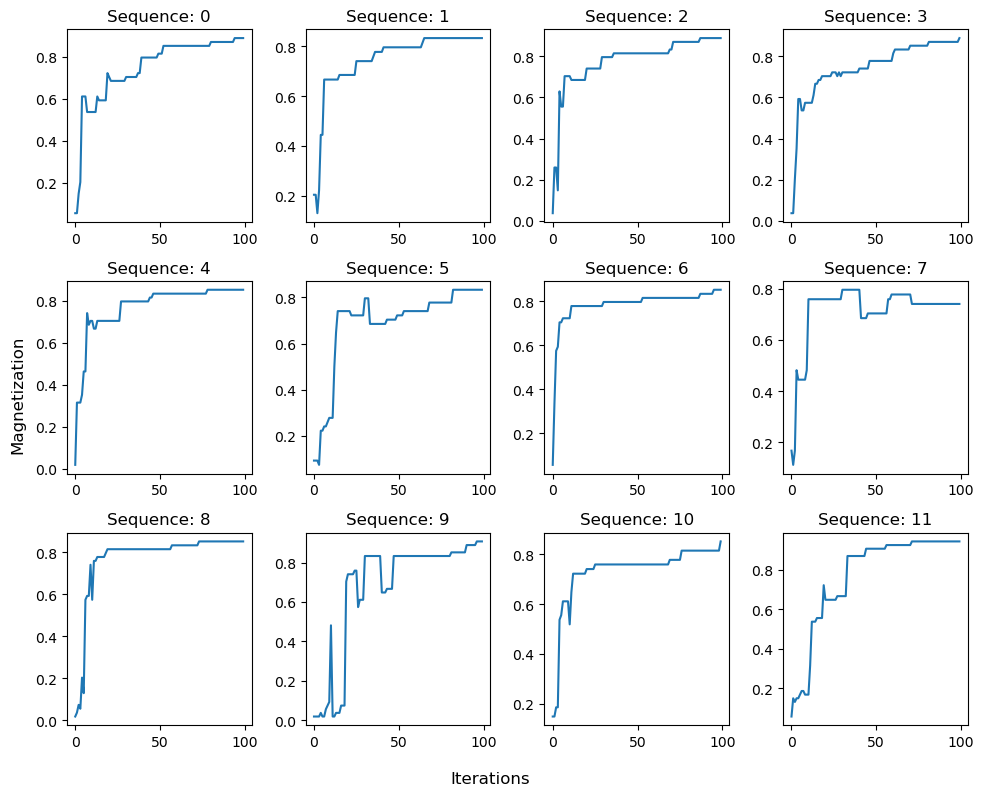

In [197]:
def plotting_magnetization(log_sequences, num_iters):
    fig, ax = plt.subplots(3, 4, figsize=(10,8))
    k = 0
    for i in range(3):
        for j in range(4):
            ax[i,j].plot(np.arange(num_iters), log_sequences[k])
            ax[i,j].set_title("Sequence: "+str(k))
            k +=1
            if k == 12:
                break
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences,100)
#print(accepted_states)
#print(log_sequences)


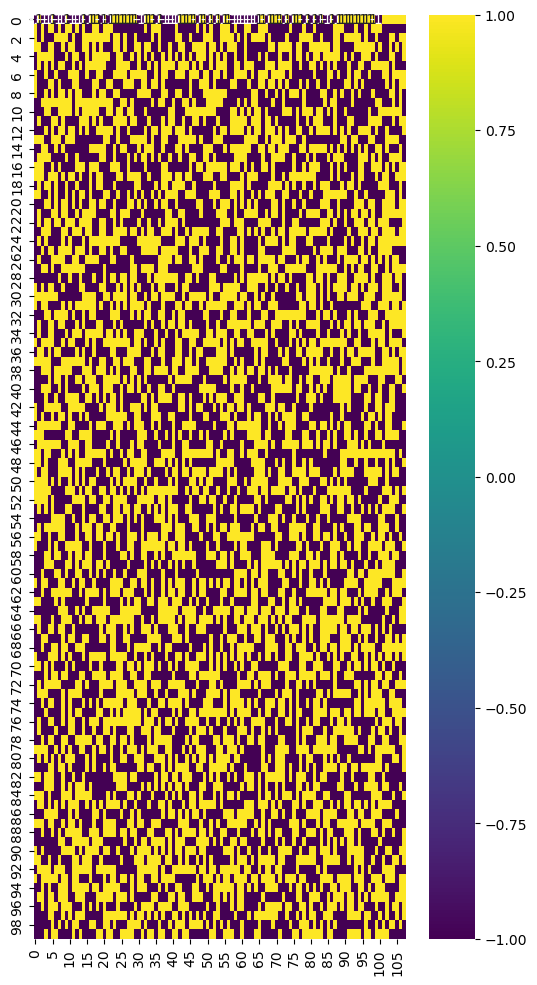

In [198]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(initial_sequences), cmap='viridis', annot=True)
plt.show()

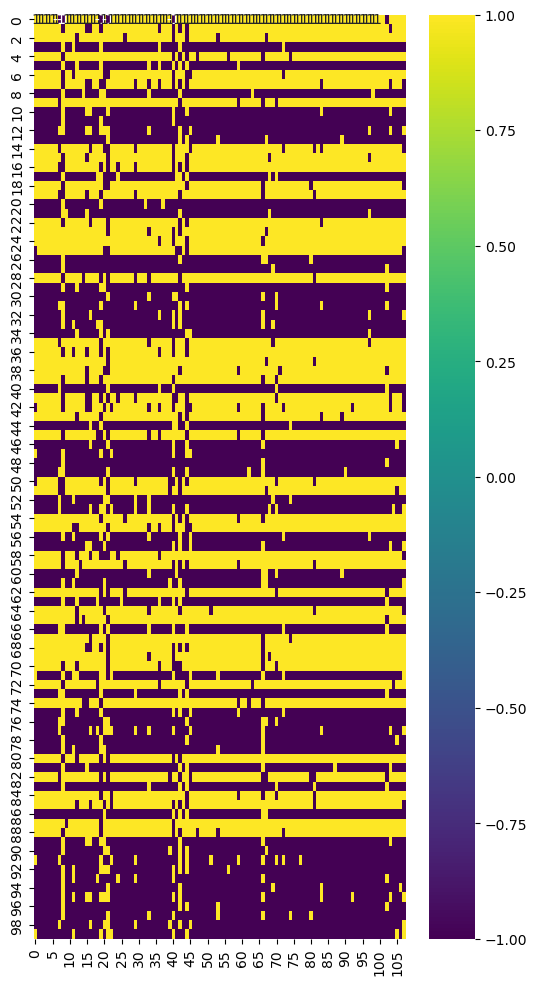

In [199]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(final_sequences_train), cmap='viridis', annot=True)
plt.show()

In [43]:
final_chains_train = np.array(final_sequences_train)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains_train.shape[0])
print("Number of spins in the chain:",final_chains_train.shape[1])

Number of chains: 1000
Number of spins in the chain: 200


In [44]:
# Save the array to a file
temp = 1 # temperature parameter
num_iters = 400 # number of iterations
np.save(f'final_chains_T={temp}_num_iters={num_iters}_J=80_train.npy', final_chains_train)
print("Numpy final chains saved!", final_chains_train.shape)

Numpy final chains saved! (1000, 200)


In [45]:
# Example usage:
np.random.seed(67)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 1000  # Number of sequences
J = set_interaction_mat(size, prob=[0.8,0.2]) # Example interaction matrix, should be symmetric
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences_test, log_sequences, accepted_states = metropolis_hastings(J, initial_sequences, num_iters=400, T=1.0, num_of_flips=10, with_T_varied=False)

final_chains_test = np.array(final_sequences_test)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains_test.shape[0])
print("Number of spins in the chain:",final_chains_test.shape[1])

Number of chains: 1000
Number of spins in the chain: 200


In [46]:
# Save the array to a file
temp = 1 # temperature parameter
num_iters = 400
np.save(f'final_chains_T={temp}_num_iters={num_iters}_J=80_test.npy', final_chains_test)
print("Numpy final chains saved!", final_chains_test.shape)

Numpy final chains saved! (1000, 200)


## Preliminary metrics for inferring the J coupling matrix
1. Calculates correlation matrix (imported from the authors implementation)
2. Calculates frequencies and coupled frequencies
3. Calculates mutual information. To calculate J, take the inferse of MI

In [17]:
def ComputeCorrelationMatrix2(mat, pseudocount):
    
    nbr_spins = len(mat[0,:])
    nbr_chains = len(mat[:,0])
    mat = np.array(mat,ndmin = 2, dtype = np.float64)
    average_spin = np.average(mat, axis = 0)[:,None]
    
    directcorr = np.dot(mat.T, mat)
    
    directcorr *= np.true_divide(1, nbr_chains, dtype = np.float64)
    
    correlation_matrix = np.dot(1.0-pseudocount, directcorr) - np.dot(pow(1-pseudocount,2),np.outer(average_spin.T, average_spin)) + np.dot(pseudocount,np.identity(nbr_spins))
    
    return correlation_matrix

corr_mat = ComputeCorrelationMatrix2(final_chains, 0.5)
#corr_mat

In [18]:
corr_mat_copy = corr_mat.copy()
corr_mat[np.round(corr_mat,2)==1] = 0
corr_mat_copy[corr_mat<np.mean(corr_mat)] = 0
corr_mat_copy[corr_mat>np.mean(corr_mat)] = 1

#plt.figure()
#sns.heatmap(np.array(corr_mat_copy), cmap='viridis', annot=True)
#plt.show()

In [19]:
def calc_frequency(mat,pseudocount):
    f = np.zeros((mat.shape[1]))
    for i in range(len(f)):
        f[i] = (1-pseudocount)*np.sum(mat[:,i] == 1)/mat.shape[0] + pseudocount/mat.shape[1]
    return f

def coupled_frequency(mat,pseudocount):
    n_seq,nbrpos = mat.shape
    nbrstates = np.unique(mat).shape[0]
    frequencies = calc_frequency(mat,pseudocount)
    binst = np.linspace(0,nbrstates, nbrstates+1)
    jointfreq = np.zeros((nbrpos,nbrpos,4))
    for i in range(0,nbrpos):    
        for j in range(0,nbrpos):
            if i != j:
                # Authors implementation
                #fri = pseudocount/(nbrstates) + (1-pseudocount)*frequencies[:,i]
                #frj = pseudocount/(nbrstates) + (1-pseudocount)*frequencies[:,j]
                #hist2d,_,_ = np.histogram2d(mat[:,i],mat[:,j],bins = binst) -> doesn't output correct result
                # Our implementation
                a, b = mat[:,i], mat[:,j]
                one_to_one = np.sum(mat[:,i][(a==b)&(a==1)])
                mone_to_mone = np.abs(np.sum(mat[:,i][(a==b)&(a==-1)]))
                mone_to_one = np.abs(np.sum(mat[:,i][(a!=b)&(a==-1)]))
                one_to_mone = np.sum(mat[:,i][(a!=b)&(a==1)])
                pair_hist = np.array([one_to_one, one_to_mone, mone_to_one, mone_to_mone])
                jointfreq[i,j,:] = (pseudocount/(nbrstates)**2) + (1-pseudocount)*pair_hist/n_seq
    return jointfreq
#print("Individual frequency for occurence of 1:",calc_frequency(final_chains, 0.5))
#print("Coupled frequency:",coupled_frequency(initial_chains, 0.5))
joint_freq = coupled_frequency(initial_chains, 0.5).reshape((200,200,2,2))
print("Shape of the frequency matrix:",joint_freq.shape)


Shape of the frequency matrix: (200, 200, 2, 2)


In [20]:
def MI(f_coupled, f_ind, mat):
    MI_calc = np.zeros((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
        for j in range(i+1, mat.shape[1]):
            #print("Coupled frequency: ",f_coupled[i,j])
            #print("Individual frequency i: ",f_ind[i])
            #print("Individual frequency j: ",f_ind[j])
            MI_calc[i,j] = -entropy(f_coupled[i,j,:]) + entropy(f_ind[i]) + entropy(f_ind[j]) #np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
            #MI_calc[i,j] = entropy(pk=f_coupled[i,j,:], qk=f_ind[i]*f_ind[j])
            #MI_calc[i,j] = f_coupled[i,j]*np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
    return MI_calc

MI_mat = MI(coupled_frequency(initial_chains, 0.5), calc_frequency(final_chains, 0.5), initial_chains)
print(MI_mat)

#J_estimated_C = np.linalg.inv(corr_mat)
#print(np.abs(J_estimated_C))

#plt.figure()
#sns.heatmap(np.array(J), cmap='viridis', annot=True)
#plt.show()

#plt.figure()
#sns.heatmap(np.array(corr_mat), vmax = 0.3, cmap='viridis', annot=True)
#plt.show()

[[ 0.         -1.38594108 -1.38611309 ... -1.38510293 -1.38528869
  -1.38602622]
 [ 0.          0.         -1.38579716 ... -1.38578132 -1.385888
  -1.38602491]
 [ 0.          0.          0.         ... -1.38596136 -1.38599972
  -1.38607698]
 ...
 [ 0.          0.          0.         ...  0.         -1.3853222
  -1.38584625]
 [ 0.          0.          0.         ...  0.          0.
  -1.38541104]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


# Direct Coupling analysis for inferring J
1. Mean field DCA (imported from authors). mfDCA -> better on simulated data
2. Pseudolikelihood maximisation DCA -> better on real data (on simulated it is overkill in terms of computing power)

> Needs to be adapted for different temperatures

### Mean-field direct coupling analysis (mfDCA)

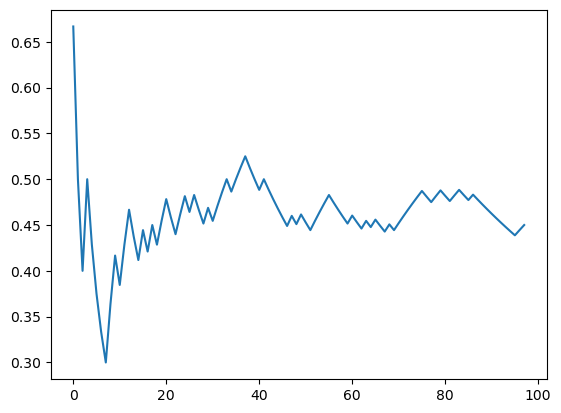

In [21]:
# imported from the supplementary code
def Inference_MF(mat_corr, matrix_contacts,bl_abs,bl_apc):
    """
    Infer the contacts using MF approximation
    """
    val,cts = np.unique(matrix_contacts,return_counts = True)
    nbrcontacts = cts[val == 1]
    flag = True
    # inverse of the correlation matrix to get the couplings
    
    try:
        inferred_couplings = np.linalg.inv(mat_corr)
    except:
        flag = False
        
    if flag:
        if bl_abs:
            inferred_couplings = np.abs(inferred_couplings)
            
        if bl_apc:
            np.fill_diagonal(inferred_couplings,0)
            S = inferred_couplings.copy()
            inferred_couplings -= (np.mean(S, axis=1, keepdims=True) * np.mean(S, axis=0, keepdims=True)) / np.mean(S)
    
        TP = []
    
        # order the 2d array and find the index of the sorted values in the matrix
        if bl_abs:
            index_sorted_array_x, index_sorted_array_y  = np.unravel_index(np.argsort(-inferred_couplings, axis=None), inferred_couplings.shape)
        else:
            index_sorted_array_x, index_sorted_array_y  = np.unravel_index(np.argsort(inferred_couplings, axis=None), inferred_couplings.shape)
    
    
        idx_flip = list(index_sorted_array_x)
        idy_flip = list(index_sorted_array_y)
    
        # indirect_corr_second_order =[]
    
        FP = []
    
        TP_coords = []
        all_coords = []
        N = 0 
        number_pairs = []
    
        list_tp = []
        TP = 0
    
        list_tp_fraction_allpairs = []
    
    
        for x, y in zip(idx_flip, idy_flip):
    
            # just look at the elements above the diagonal as symmetric matrix
            # to not count twice each contact
            if y > x:
    
                N = N + 1
    
                number_pairs.append(N)

    
                if matrix_contacts[x,y] == 1:
                    TP = TP + 1
                    if N <= nbrcontacts:
                        TP_coords.append([x,y])
                else:
    
                    if N <= nbrcontacts:
                        FP.append([x,y])

    
                list_tp.append(TP)
    
                all_coords.append([x,y])
    
                list_tp_fraction_allpairs.append(TP/N)
    
        return list_tp_fraction_allpairs, FP
    
    else:
        mat = np.zeros(nbrcontacts)
        mat[:] = np.nan
        return mat,mat
list_tp_fraction_allpairs, FP = Inference_MF(corr_mat, J,bl_abs=True,bl_apc=False)
plt.plot(list_tp_fraction_allpairs[2:100])

### Pseudo-likelihood maximisation with direct coupling analysis (plmDCA)

In [22]:
import numpy as np
from sklearn import metrics

def compute_frobenius_norm(J, apply_apc=False):
    """Compute Frobenius norm scores from couplings, optionally apply APC correction."""
    # Zero-sum gauge transformation
    J -= np.mean(J, axis=(2, 3), keepdims=True)
    J -= np.mean(J, axis=(0, 1), keepdims=True)
    J += np.mean(J)
    
    # Frobenius norm
    scores = np.sqrt(np.sum(J**2, axis=(2, 3)))
    
    # APC correction
    if apply_apc:
        mean_row = np.mean(scores, axis=1, keepdims=True)
        mean_col = np.mean(scores, axis=0, keepdims=True)
        mean_all = np.mean(scores)
        scores -= mean_row * mean_col / mean_all
    
    return scores


def inference_plmDCA(scores, true_contacts):
    """Infer contacts from scores and calculate true positive fraction."""
    nbr_contacts = np.sum(true_contacts)
    nbr_noncontacts = np.prod(true_contacts.shape) - nbr_contacts
    
    sorted_indices = np.unravel_index(np.argsort(-scores, axis=None), scores.shape)
    sorted_true_contacts = true_contacts[sorted_indices]
    
    tp = np.cumsum(sorted_true_contacts)
    fp = np.cumsum(1 - sorted_true_contacts)
    
    tp_rate = tp / nbr_contacts
    fp_rate = fp / nbr_noncontacts
    
    auc = metrics.auc(fp_rate, tp_rate)
    tp_fraction = tp[nbr_contacts - 1] / nbr_contacts
    
    return auc, tp_fraction

def example_plmDCA(J, joint_freq):
    """Example usage of plmDCA inference."""
    # Load couplings and parameters
    #path = 'path_to_data.h5'
    #Jtensor, regparam = load_couplings_and_params(path)
    Jtensor = joint_freq
    # Assume matrix_contact is given
    matrix_contact = J
    
    # Compute scores using Frobenius norm and apply APC
    Jtensor = Jtensor[:, :, :, :]
    scores = compute_frobenius_norm(Jtensor, apply_apc=True)
    
    # Infer contacts and calculate performance metrics
    auc, tp_fraction = inference_plmDCA(scores, matrix_contact)
    
    print(f'AUC: {auc}, TP Fraction: {tp_fraction}')
    return tp_fraction

# Uncomment to run the example
example_plmDCA(J, joint_freq)


AUC: 0.5060190117286323, TP Fraction: 0.5039425092324583


0.5039425092324583

### Adapting for temperature
The following changes from previous code are present:
- propose_sequence function has flip_decision variable dependent on temperature
- metropolis_hastings function does not randomly select number of flips in the loop

> to make sure this changes are present: with_T_varied should be true

In [26]:
# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 400  # Number of sequences
J = set_interaction_mat(size) # Example interaction matrix, should be symmetric
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences, log_sequences, accepted_states = metropolis_hastings(J, initial_sequences, num_iters=1000, T=10.0, num_of_flips=10, with_T_varied=True)
# Final_sequences contains the sequences after they have potentially reached their stable states

print(np.array(final_sequences).shape)

(400, 200)


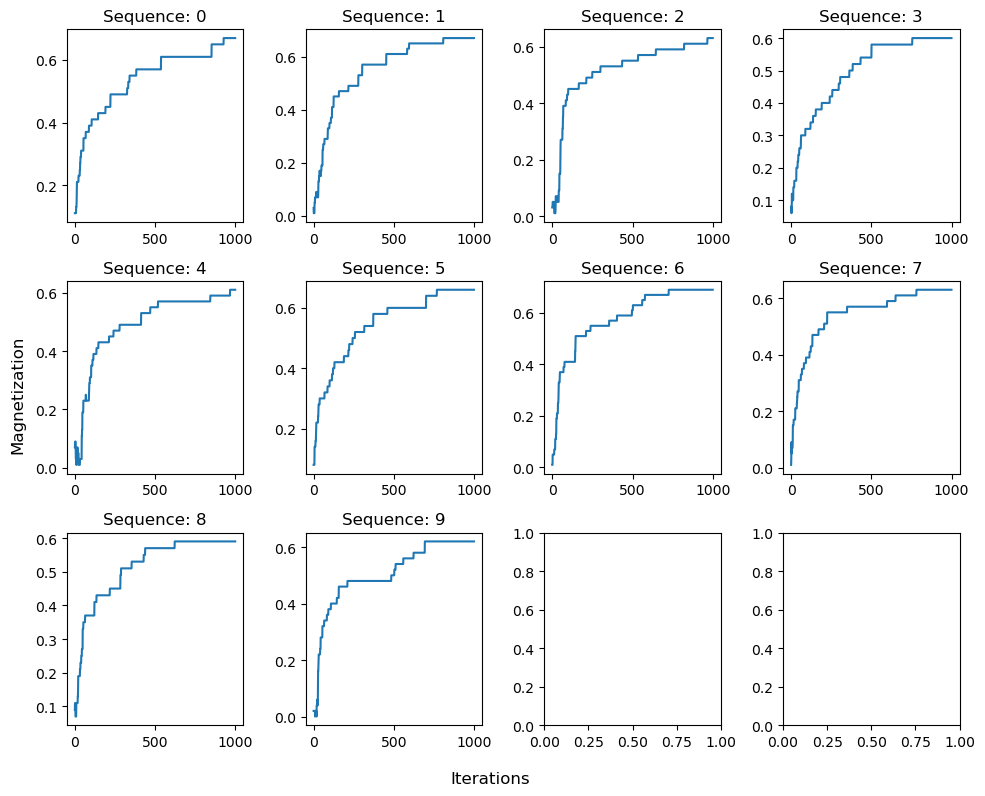

In [27]:
def plotting_magnetization(log_sequences, num_iters):
    fig, ax = plt.subplots(3, 4, figsize=(10,8))
    k = 0
    for i in range(3):
        for j in range(4):
            ax[i,j].plot(np.arange(num_iters), log_sequences[k])
            ax[i,j].set_title("Sequence: "+str(k))
            k +=1
            if k == 10:
                break
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences, 1000)
#print(accepted_states)
#print(log_sequences)


In [156]:
temp_list = np.arange(1,100,10)
pseudocount = 0.5
final_sequences_temp = np.zeros((num_sequences, size, len(temp_list)))
joint_freq_temp = np.zeros((size,size,2,2,len(temp_list)))
print(final_sequences_temp.shape)
for i,t in enumerate(temp_list):
    print(t)
    final_sequences_temp[:,:,i],__,__ = metropolis_hastings(J, initial_sequences, num_iters=200, T=t, num_of_flips=10)
    print(np.sum(final_sequences_temp[:10,:,i], axis=1))
    joint_freq_temp[:,:,:,:,i] = coupled_frequency(final_sequences_temp[:,:,i],pseudocount).reshape((200,200,2,2))
    print(joint_freq_temp[0,1,:,:,i])
    #Jf = joint_freq_temp[:,:,:,:,t-1].reshape((200,200,2,2))
    example_plmDCA(J, joint_freq_temp[:,:,:,:,i])


(400, 200, 10)
1
[-66.  80. -74. -62. -74. -62. -74.  78. -58.  80.]
[[0.26375 0.23375]
 [0.2375  0.265  ]]
AUC: 0.49558102225116674, TP Fraction: 0.750091718640563
11
[-68.  66. -66. -66.  78.  66. -62.  76. -72. -82.]
[[0.25625 0.24375]
 [0.21625 0.28375]]
AUC: 0.4935222568686563, TP Fraction: 0.750225127572291
21
[-76.  88.  84. -84.  74. -84. -82.  84.  96.  94.]
[[0.275   0.23375]
 [0.225   0.26625]]
AUC: 0.4979047043166397, TP Fraction: 0.7488243337891471
31
[-106.   74.   84.  -92.  -78.   94.  -88.  106.  -86.  -82.]
[[0.2775  0.22375]
 [0.23125 0.2675 ]]
AUC: 0.4852762410762259, TP Fraction: 0.7478237668011873
41
[ 94.  82. -84. 106. 104. 102.  98.  94. -88. 102.]
[[0.275   0.21125]
 [0.23    0.28375]]
AUC: 0.49527433952948036, TP Fraction: 0.750158423106427
51
[ 100. -108. -102.  100.  108. -100.  -94.   98.  102.  100.]
[[0.285   0.2    ]
 [0.21125 0.30375]]
AUC: 0.49448088468061424, TP Fraction: 0.7511589900943868
61
[ 108.  106.  -98.  116.  102.   98.  -96.   96. -110. -1

### Some other implementations

In [ ]:
def identify_and_flip_clusters(current_sequence, J, T):
    """
    Identify clusters based on J and propose a new sequence by flipping one of these clusters.
    Args:
        current_sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix providing lattice and neighborhood information.
        T (float): Temperature, influencing the probability of flipping a cluster.
    Returns:
        np.array: The proposed sequence of spins after possibly flipping a cluster.
    """
    new_sequence = current_sequence.copy()
    size = len(current_sequence)
    # Randomly choose a starting point for the cluster
    start_index = np.random.randint(size)
    cluster = [start_index]
    beta = 1/T
    probability = 1.0 - np.exp(-2.0*beta)
    for i in cluster:
        for j in range(size):
            # If spins are interacting strongly and not yet in the cluster, add them
            if (J[i, j] > 0) and (j not in cluster) and (current_sequence[i] == current_sequence[j]):
                # Add to the cluster based on a probability related to the interaction strength and temperature
                if np.random.rand() < probability:
                    #print("we are in if statement")
                    #print(np.exp(-J[i, j] / T))
                    cluster.append(j)
                #else:
                    #print("we are in else statement")
                    #print(np.exp(-J[i, j] / T))
    
    # Flip the entire cluster with some probability (could be based on size, energy, etc.)
    #if np.random.rand() < 0.5:  # Example probability, adjust as needed
    for i in cluster:
        new_sequence[i] = -new_sequence[i]
    
    return new_sequence